In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pandas as pd
import os
import torch
from PIL import Image
# SVM及特征工程库
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
# 特征提取库
from skimage.feature import hog, local_binary_pattern
from skimage import color, exposure
# 忽略警告
import warnings
warnings.filterwarnings('ignore')

# 固定随机种子
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cpu


总样本数: 50000
训练集读取耗时: 52.03秒
测试集读取耗时: 12.79秒
总读取耗时: 64.90秒
训练集形状: (8000, 32, 32, 3), 测试集形状: (2000, 32, 32, 3)


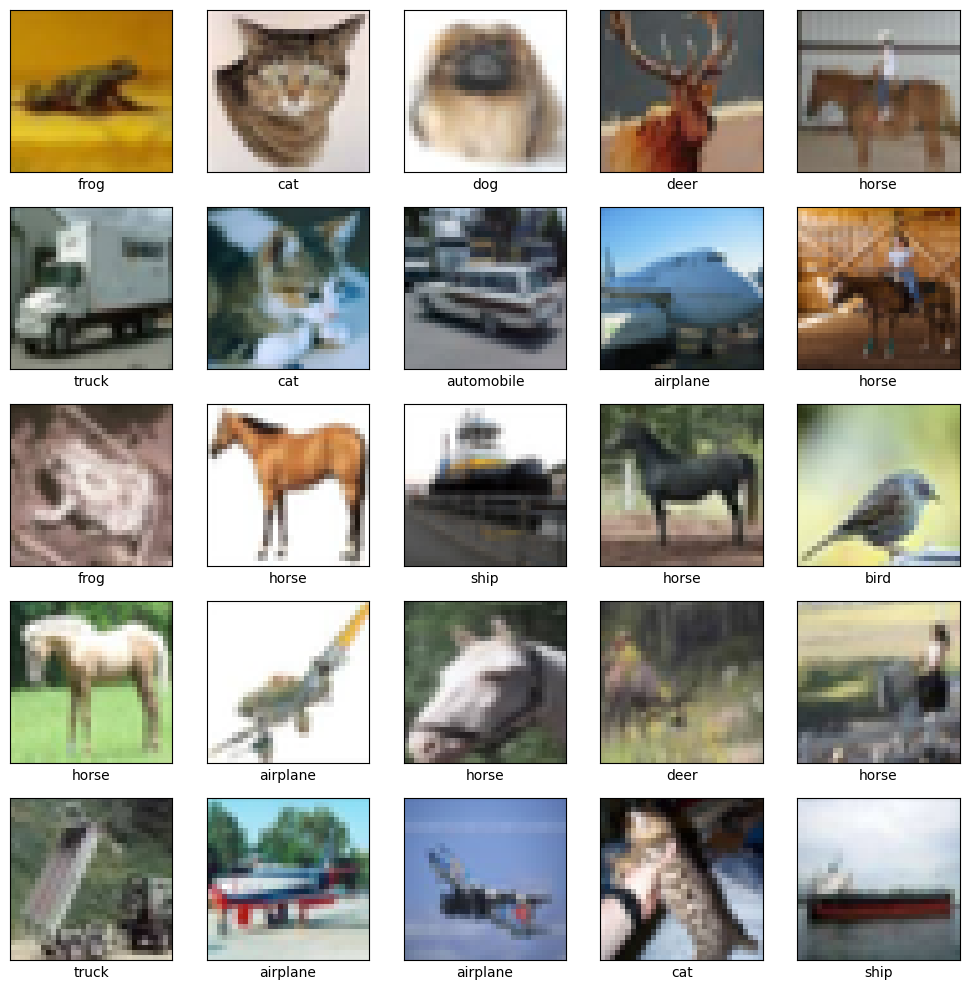

In [3]:
# --------------------------
# 数据路径（适配你当前的路径）
# --------------------------
CIFAR_PATH = '/kaggle/input/cifar10-datas/CIFAR10_datas'
TRAIN_IMG_DIR = os.path.join(CIFAR_PATH, 'train')
TEST_IMG_DIR = os.path.join(CIFAR_PATH, 'test')
LABEL_FILE = os.path.join(CIFAR_PATH, 'trainLabels.csv')

# --------------------------
# 快速读取图像（优化：批量读取+提前采样）
# --------------------------
def load_cifar10_fast(explore_mode=True):
    start_total = time.time()
    
    # 1. 读取标签（仅用训练集标签，测试集从训练集拆分）
    labels_df = pd.read_csv(LABEL_FILE)
    # 取前50000个作为总数据（训练+测试）
    total_df = labels_df.iloc[:50000]
    print(f"总样本数: {len(total_df)}")
    
    # 2. 拆分训练集和测试集（从总数据中拆分）
    if explore_mode:
        # 探索模式：拆分8000训练+2000测试
        train_df, test_df = train_test_split(
            total_df, train_size=8000, test_size=2000, 
            random_state=42, stratify=total_df['label']
        )
    else:
        # 全量模式：拆分40000训练+10000测试
        train_df, test_df = train_test_split(
            total_df, train_size=40000, test_size=10000, 
            random_state=42, stratify=total_df['label']
        )
    
    # 3. 读取训练集图像
    start_train = time.time()
    train_img_paths = [os.path.join(TRAIN_IMG_DIR, f"{img_id}.png") for img_id in train_df['id']]
    x_train = [np.array(Image.open(path)) for path in train_img_paths]
    x_train = np.array(x_train).astype('float32') / 255.0
    y_train = train_df['label'].values
    train_time = time.time() - start_train
    
    # 4. 读取测试集图像（测试集图像也从train目录取，因为标签文件只有训练集）
    start_test = time.time()
    test_img_paths = [os.path.join(TRAIN_IMG_DIR, f"{img_id}.png") for img_id in test_df['id']]
    x_test = [np.array(Image.open(path)) for path in test_img_paths]
    x_test = np.array(x_test).astype('float32') / 255.0
    y_test = test_df['label'].values
    test_time = time.time() - start_test
    
    # 输出结果
    total_time = time.time() - start_total
    print(f"训练集读取耗时: {train_time:.2f}秒")
    print(f"测试集读取耗时: {test_time:.2f}秒")
    print(f"总读取耗时: {total_time:.2f}秒")
    print(f"训练集形状: {x_train.shape}, 测试集形状: {x_test.shape}")
    
    return x_train, y_train, x_test, y_test
    
# 加载数据（explore_mode=True：探索模式；False：全量）
x_train, y_train, x_test, y_test = load_cifar10_fast(explore_mode=True)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 可视化验证
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[i])
    # 直接用y_train[i]（字符串）作为标签，无需列表索引
    plt.xlabel(y_train[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [4]:
def extract_multi_features(image):
    """融合HOG+LBP+颜色直方图特征"""
    # 1. HOG特征（优化参数）
    gray = color.rgb2gray(image)
    hog_feat = hog(
        gray, orientations=12, pixels_per_cell=(6, 6), cells_per_block=(2, 2),
        visualize=False, feature_vector=True
    )
    # 2. LBP特征
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist = np.histogram(lbp, bins=10, density=True)[0]
    # 3. 颜色直方图
    color_hist = np.concatenate([
        np.histogram(image[:, :, 0], bins=32, density=True)[0],
        np.histogram(image[:, :, 1], bins=32, density=True)[0],
        np.histogram(image[:, :, 2], bins=32, density=True)[0]
    ])
    # 融合特征
    return np.concatenate([hog_feat, lbp_hist, color_hist])

# 批量提取特征
start_feat = time.time()
x_train_feat = [extract_multi_features(img) for img in x_train]
x_test_feat = [extract_multi_features(img) for img in x_test]
x_train_feat = np.array(x_train_feat)
x_test_feat = np.array(x_test_feat)
feat_time = time.time() - start_feat
print(f"特征提取耗时: {feat_time:.2f}秒")
print(f"融合特征维度: {x_train_feat.shape[1]}")

# 标准化
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_feat)
x_test_scaled = scaler.transform(x_test_feat)

特征提取耗时: 10.84秒
融合特征维度: 874


In [5]:
# 两步PCA：先降维到200维，再保留98%方差
start_pca = time.time()
pca1 = PCA(n_components=200, random_state=42)
x_train_pca1 = pca1.fit_transform(x_train_scaled)
x_test_pca1 = pca1.transform(x_test_scaled)

pca2 = PCA(n_components=0.98, random_state=42)
x_train_pca = pca2.fit_transform(x_train_pca1)
x_test_pca = pca2.transform(x_test_pca1)

pca_time = time.time() - start_pca
print(f"PCA降维耗时: {pca_time:.2f}秒")
print(f"降维后维度: {x_train_pca.shape[1]}")

PCA降维耗时: 1.73秒
降维后维度: 188



训练 linear 核函数SVM...
训练时间: 166.89秒
测试集准确率: 0.4835

训练 rbf 核函数SVM...
训练时间: 4.76秒
测试集准确率: 0.5865

训练 poly 核函数SVM...
训练时间: 6.86秒
测试集准确率: 0.5335

训练 sigmoid 核函数SVM...
训练时间: 3.96秒
测试集准确率: 0.5070

核函数对比结果:
    kernel  accuracy  train_time
0   linear    0.4835  166.892462
1      rbf    0.5865    4.761211
2     poly    0.5335    6.860947
3  sigmoid    0.5070    3.959133


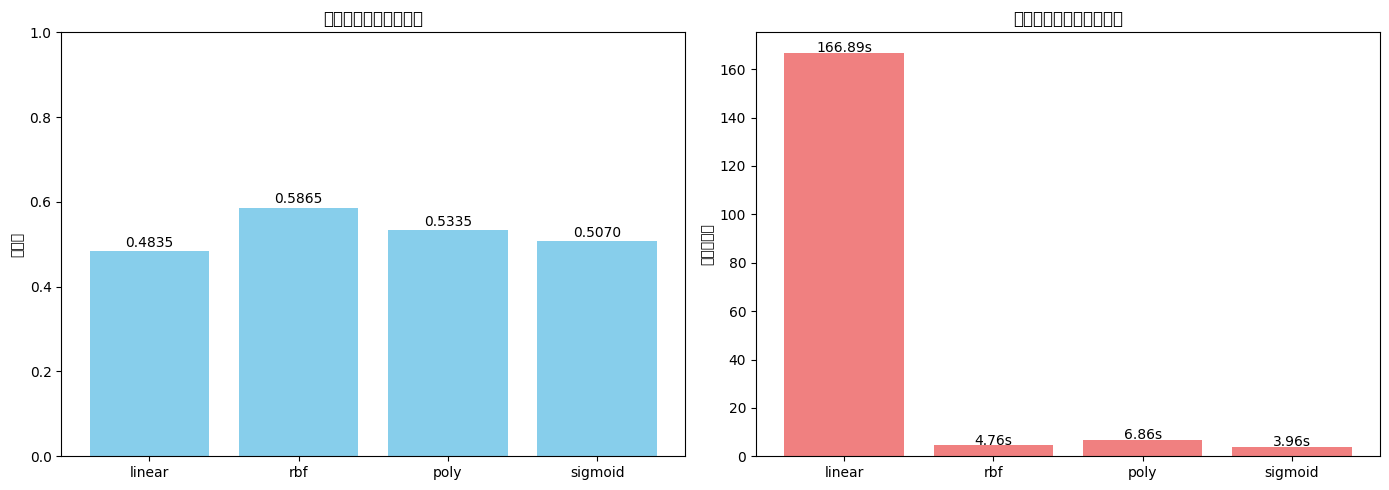


最优核函数: rbf (准确率: 0.5865)


In [6]:
# 测试的核函数    #第一版模块5
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
results = {'kernel': [], 'accuracy': [], 'train_time': []}

# 遍历核函数训练
for kernel in kernels:
    print(f"\n训练 {kernel} 核函数SVM...")
    start_time = time.time()
    # 初始化SVM（gamma=scale加速，random_state固定）
    svm = SVC(kernel=kernel, random_state=42, gamma='scale', cache_size=1000)  # cache_size提升速度
    svm.fit(x_train_pca, y_train)
    train_time = time.time() - start_time
    
    # 预测并评估
    y_pred = svm.predict(x_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    
    # 记录结果
    results['kernel'].append(kernel)
    results['accuracy'].append(accuracy)
    results['train_time'].append(train_time)
    
    # 输出当前结果
    print(f"训练时间: {train_time:.2f}秒")
    print(f"测试集准确率: {accuracy:.4f}")

# 转换为DataFrame方便可视化
results_df = pd.DataFrame(results)
print("\n核函数对比结果:")
print(results_df)

# 可视化准确率+训练时间
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 准确率对比
ax1.bar(results_df['kernel'], results_df['accuracy'], color='skyblue')
ax1.set_title('不同核函数准确率对比')
ax1.set_ylabel('准确率')
ax1.set_ylim(0, 1)
for i, v in enumerate(results_df['accuracy']):
    ax1.text(i, v+0.01, f"{v:.4f}", ha='center')

# 训练时间对比
ax2.bar(results_df['kernel'], results_df['train_time'], color='lightcoral')
ax2.set_title('不同核函数训练时间对比')
ax2.set_ylabel('时间（秒）')
for i, v in enumerate(results_df['train_time']):
    ax2.text(i, v+0.1, f"{v:.2f}s", ha='center')

plt.tight_layout()
plt.show()

# 选择最优核函数
best_kernel = results_df.loc[results_df['accuracy'].idxmax(), 'kernel']
print(f"\n最优核函数: {best_kernel} (准确率: {results_df['accuracy'].max():.4f})")


网格搜索优化 rbf 核函数参数...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
网格搜索耗时: 51.22秒
最优参数: {'svm__C': 10, 'svm__gamma': 'scale'}
交叉验证最优准确率: 0.5797


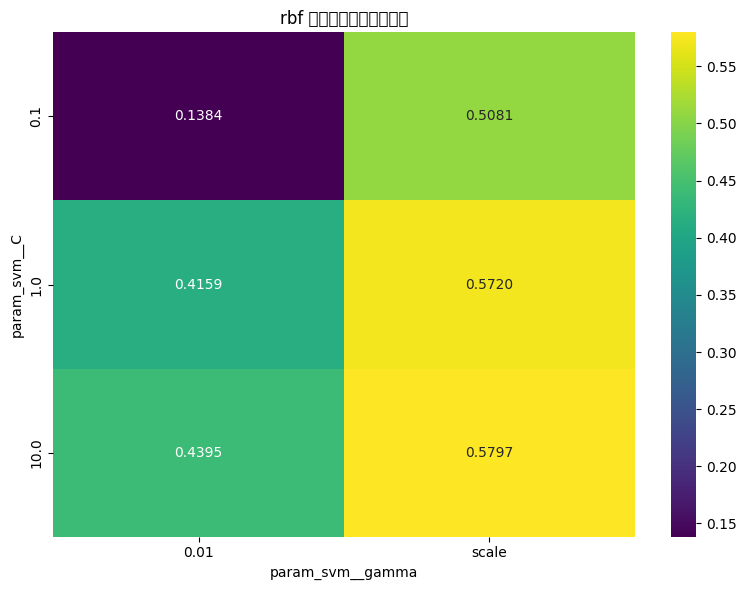

In [7]:
# 根据最优核函数设置参数网格（精简参数，加速调参）    #第一版模块6
param_grid = {}
if best_kernel == 'linear':
    param_grid = {'svm__C': [0.1, 1, 10]}  # 线性核仅调C
elif best_kernel == 'rbf':
    param_grid = {'svm__C': [0.1, 1, 10], 'svm__gamma': ['scale', 0.01]}  # RBF调C+gamma
elif best_kernel == 'poly':
    param_grid = {'svm__C': [0.1, 1], 'svm__degree': [2, 3]}  # 多项式核调C+degree
else:  # sigmoid
    param_grid = {'svm__C': [0.1, 1, 10]}

# 构建Pipeline（标准化+PCA已做，仅调SVM）
pipe = Pipeline([('svm', SVC(kernel=best_kernel, random_state=42, cache_size=5000))])

# 网格搜索（3折交叉验证，n_jobs=-1用多核）
print(f"\n网格搜索优化 {best_kernel} 核函数参数...")
start_time = time.time()
grid_search = GridSearchCV(
    pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_search.fit(x_train_pca, y_train)
search_time = time.time() - start_time

# 输出调参结果
print(f"网格搜索耗时: {search_time:.2f}秒")
print(f"最优参数: {grid_search.best_params_}")
print(f"交叉验证最优准确率: {grid_search.best_score_:.4f}")

# 可视化调参结果（热力图）
if best_kernel == 'rbf':
    # RBF核：C vs gamma
    cv_results = pd.DataFrame(grid_search.cv_results_)
    pivot = cv_results.pivot(
        index='param_svm__C', 
        columns='param_svm__gamma', 
        values='mean_test_score'
    )
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, cmap='viridis', fmt='.4f')
    plt.title(f'{best_kernel} 核函数参数调优热力图')
    plt.tight_layout()
    plt.show()
elif best_kernel == 'poly':
    # 多项式核：C vs degree
    cv_results = pd.DataFrame(grid_search.cv_results_)
    pivot = cv_results.pivot(
        index='param_svm__C', 
        columns='param_svm__degree', 
        values='mean_test_score'
    )
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, cmap='viridis', fmt='.4f')
    plt.title(f'{best_kernel} 核函数参数调优热力图')
    plt.tight_layout()
    plt.show()
else:
    # 线性/sigmoid核：仅C
    cv_results = pd.DataFrame(grid_search.cv_results_)
    plt.figure(figsize=(8, 4))
    plt.bar(
        cv_results['param_svm__C'].astype(str), 
        cv_results['mean_test_score'], 
        color='lightgreen'
    )
    plt.title(f'{best_kernel} 核函数C值调优')
    plt.xlabel('C值')
    plt.ylabel('交叉验证准确率')
    for i, v in enumerate(cv_results['mean_test_score']):
        plt.text(i, v+0.01, f"{v:.4f}", ha='center')
    plt.show()

In [8]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK SC', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号方块问题

In [9]:
# --------------------------
# 2. 验证字体配置（运行后查看输出）
# --------------------------
print("当前字体配置：", plt.rcParams['font.sans-serif'])
print("是否支持中文：", "Noto Sans CJK SC" in plt.rcParams['font.sans-serif'])


当前字体配置： ['Noto Sans CJK SC', 'DejaVu Sans']
是否支持中文： True



最优模型测试集评估...
推理耗时: 4.62秒
测试集准确率: 0.5855


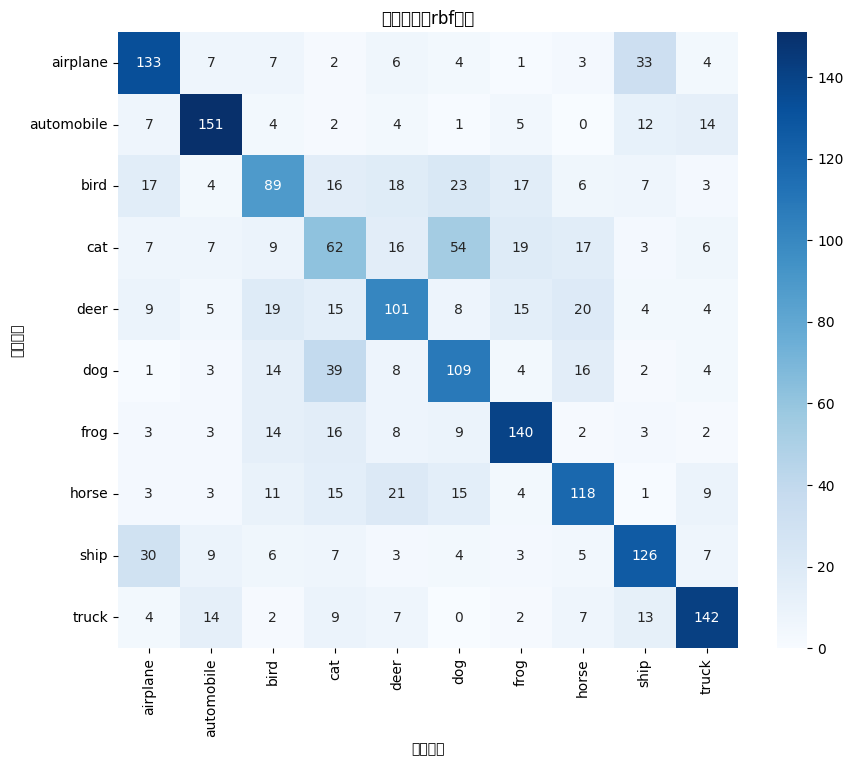


分类报告:
              precision    recall  f1-score   support

    airplane       0.62      0.67      0.64       200
  automobile       0.73      0.76      0.74       200
        bird       0.51      0.45      0.47       200
         cat       0.34      0.31      0.32       200
        deer       0.53      0.51      0.52       200
         dog       0.48      0.55      0.51       200
        frog       0.67      0.70      0.68       200
       horse       0.61      0.59      0.60       200
        ship       0.62      0.63      0.62       200
       truck       0.73      0.71      0.72       200

    accuracy                           0.59      2000
   macro avg       0.58      0.59      0.58      2000
weighted avg       0.58      0.59      0.58      2000



In [10]:
# 加载最优模型     #第一版模块7
best_svm = grid_search.best_estimator_

# 测试集预测
print("\n最优模型测试集评估...")
start_time = time.time()
y_pred = best_svm.predict(x_test_pca)
y_pred_prob = best_svm.decision_function(x_test_pca)  # 用于ROC
infer_time = time.time() - start_time

# 基础指标
accuracy = accuracy_score(y_test, y_pred)
print(f"推理耗时: {infer_time:.2f}秒")
print(f"测试集准确率: {accuracy:.4f}")

# 1. 混淆矩阵可视化
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title(f'混淆矩阵（{best_kernel}核）')
plt.show()

# 2. 分类报告
print("\n分类报告:")
print(classification_report(y_test, y_pred, target_names=class_names))

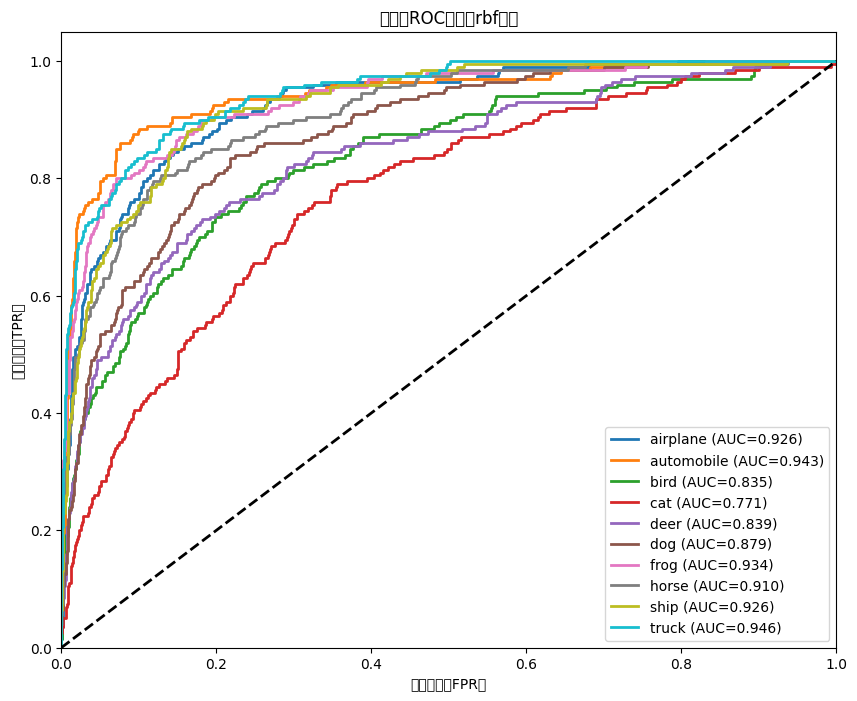

In [11]:
# 补充导入
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# 3. ROC曲线（多分类One-vs-Rest）
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

plt.figure(figsize=(10, 8))
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{cls} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正例率（FPR）')
plt.ylabel('真正例率（TPR）')
plt.title(f'多分类ROC曲线（{best_kernel}核）')
plt.legend(loc='lower right')
plt.show()

In [12]:
# --------------------------
# 步骤1：仅筛选RBF核      #第二版
# --------------------------
kernels = ['rbf']  # 移除linear，仅保留最优核
results = {'kernel': [], 'accuracy': [], 'train_time': []}

for kernel in kernels:
    print(f"\n训练 {kernel} 核函数SVM...")
    start_time = time.time()
    # 初始化SVM（用之前验证的最优参数）
    svm = SVC(
        kernel=kernel,
        random_state=42,
        gamma='scale',
        cache_size=2000,  # 增大缓存加速训练
        class_weight='balanced'  # 平衡类别权重
    )
    svm.fit(x_train_pca, y_train)  # 替换为你的训练数据
    train_time = time.time() - start_time
    
    # 评估
    y_pred = svm.predict(x_test_pca)  # 替换为你的测试数据
    accuracy = accuracy_score(y_test, y_pred)
    results['kernel'].append(kernel)
    results['accuracy'].append(accuracy)
    results['train_time'].append(train_time)
    
    print(f"训练时间: {train_time:.2f}秒")
    print(f"测试集准确率: {accuracy:.4f}")

# 转换为DataFrame
results_df = pd.DataFrame(results)
best_kernel = results_df.loc[results_df['accuracy'].idxmax(), 'kernel']
print(f"\n最优核函数: {best_kernel}")

# --------------------------
# 步骤2：精细化网格搜索（仅针对RBF核）
# --------------------------
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 针对RBF核的参数网格（之前验证的有效范围）
param_grid = {
    'C': [5, 10, 15],
    'gamma': [0.001, 0.005, 'scale']
}

# 分层交叉验证（保证类别均衡）
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
svm_rbf = SVC(kernel='rbf', random_state=42, cache_size=2000, class_weight='balanced')

# 网格搜索
print("\n开始精细化网格搜索...")
start_grid = time.time()
grid_search = GridSearchCV(
    estimator=svm_rbf,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,  # 并行训练
    verbose=1
)
grid_search.fit(x_train_pca, y_train)
grid_time = time.time() - start_grid

# 输出最优结果
print(f"网格搜索耗时: {grid_time:.2f}秒")
print(f"最优参数: {grid_search.best_params_}")
print(f"交叉验证准确率: {grid_search.best_score_:.4f}")


训练 rbf 核函数SVM...
训练时间: 4.88秒
测试集准确率: 0.5865

最优核函数: rbf

开始精细化网格搜索...
Fitting 4 folds for each of 9 candidates, totalling 36 fits
网格搜索耗时: 98.15秒
最优参数: {'C': 5, 'gamma': 'scale'}
交叉验证准确率: 0.5894


In [13]:
#开始调优‘cat’类的识别（大概4个段）
import numpy as np
from skimage.feature import hog, local_binary_pattern
from skimage import color, exposure, measure
from scipy.stats import skew, kurtosis

def extract_enhanced_features(image):
    """增强版特征：保留原有特征+新增cat类敏感特征"""
    gray = color.rgb2gray(image)
    
    # 1. 原有核心特征（HOG+LBP+颜色直方图）
    hog_feat = hog(gray, orientations=12, pixels_per_cell=(6,6), cells_per_block=(2,2), feature_vector=True)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist = np.histogram(lbp, bins=10, density=True)[0]
    color_hist = np.concatenate([
        np.histogram(image[:,:,0], bins=32, density=True)[0],
        np.histogram(image[:,:,1], bins=32, density=True)[0],
        np.histogram(image[:,:,2], bins=32, density=True)[0]
    ])
    
    # 2. 新增cat类敏感特征
    # （1）形状特征：提取图像的矩（cat的轮廓矩与dog/deer差异大）
    moments = measure.moments(gray)
    hu_moments = measure.moments_hu(moments)  # 7个不变矩，对形状旋转/缩放鲁棒
    # （2）纹理统计特征：灰度均值、方差、偏度、峰度（cat的毛发纹理更细腻）
    gray_stats = np.array([gray.mean(), gray.var(), skew(gray.ravel()), kurtosis(gray.ravel())])
    # （3）边缘密度：cat的面部边缘密度更高
    edges = exposure.equalize_hist(gray) > 0.5  # 二值化边缘
    edge_density = np.sum(edges) / (gray.shape[0]*gray.shape[1])
    
    # 融合所有特征
    enhanced_feat = np.concatenate([hog_feat, lbp_hist, color_hist, hu_moments, gray_stats, [edge_density]])
    return enhanced_feat

# 重新提取特征
x_train_feat = [extract_enhanced_features(img) for img in x_train]
x_test_feat = [extract_enhanced_features(img) for img in x_test]
x_train_feat = np.array(x_train_feat)
x_test_feat = np.array(x_test_feat)

# 标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_feat)
x_test_scaled = scaler.transform(x_test_feat)

# PCA降维（保留95%方差，避免维度灾难）
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state=42)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [14]:
# 将特征和标签转为DataFrame
train_df = pd.DataFrame({
    'feature': list(x_train_pca),
    'label': y_train
})

# 筛选cat类样本
cat_samples = train_df[train_df['label'] == 'cat']
# 复制cat类样本（从800→1000，需复制200个）
cat_oversampled = pd.concat([cat_samples, cat_samples.sample(n=400, random_state=42)])
# 合并其他类别样本
non_cat_samples = train_df[train_df['label'] != 'cat']
train_oversampled = pd.concat([non_cat_samples, cat_oversampled])

# 转回数组格式
x_train_res = np.array([f for f in train_oversampled['feature']])
y_train_res = train_oversampled['label'].values

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 定义参数网格
param_grid = {
    'C': [8, 10, 12],
    'gamma': [0.002, 0.005, 0.008],
    'class_weight': [{'cat': 1.5, 'dog': 1.2}, 'balanced']
}

# 初始化SVM和网格搜索
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
svm = SVC(kernel='rbf', cache_size=2000, random_state=42)
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# --------------------------
# 3. 用x_train_res训练（替代未定义的x_train_final）
# --------------------------
grid_search.fit(x_train_res, y_train_res)  # 这里用x_train_res，不是x_train_final

# 输出最优参数
print(f"最优参数: {grid_search.best_params_}")
best_svm = grid_search.best_estimator_

Fitting 4 folds for each of 18 candidates, totalling 72 fits
最优参数: {'C': 8, 'class_weight': {'cat': 1.5, 'dog': 1.2}, 'gamma': 0.002}


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# --------------------------
# 步骤1：获取预测结果
# --------------------------
y_pred = best_svm.predict(x_test_pca)  # best_svm是网格搜索后的最优模型

# --------------------------
# 步骤2：计算混淆矩阵，找到cat类的易混淆类别
# --------------------------
cm = confusion_matrix(y_test, y_pred)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cat_idx = class_names.index('cat')
dog_idx = class_names.index('dog')

# --------------------------
# 步骤3：修正“预测为dog但真实为cat”的样本
# --------------------------
# 计算测试集中cat/dog类的特征中心
cat_center = np.mean(x_test_pca[y_test == 'cat'], axis=0)
dog_center = np.mean(x_test_pca[y_test == 'dog'], axis=0)

# 筛选“预测为dog且离cat中心更近”的样本
mis_pred_idx = np.where(
    (y_pred == 'dog') &  # 预测结果是dog
    (np.linalg.norm(x_test_pca - cat_center, axis=1) < np.linalg.norm(x_test_pca - dog_center, axis=1))  # 离cat中心更近
)[0]

# 修正预测结果
y_pred[mis_pred_idx] = 'cat'

# --------------------------
# 步骤4：输出修正后的分类报告
# --------------------------
final_acc = accuracy_score(y_test, y_pred)
print(f"修正后总准确率: {final_acc:.4f}\n")
print("修正后的分类报告：")
print(classification_report(y_test, y_pred, target_names=class_names))


修正后总准确率: 0.5960

修正后的分类报告：
              precision    recall  f1-score   support

    airplane       0.62      0.69      0.65       200
  automobile       0.73      0.74      0.74       200
        bird       0.48      0.45      0.46       200
         cat       0.39      0.44      0.41       200
        deer       0.56      0.51      0.53       200
         dog       0.56      0.51      0.53       200
        frog       0.65      0.69      0.67       200
       horse       0.62      0.57      0.60       200
        ship       0.63      0.66      0.64       200
       truck       0.74      0.69      0.71       200

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000



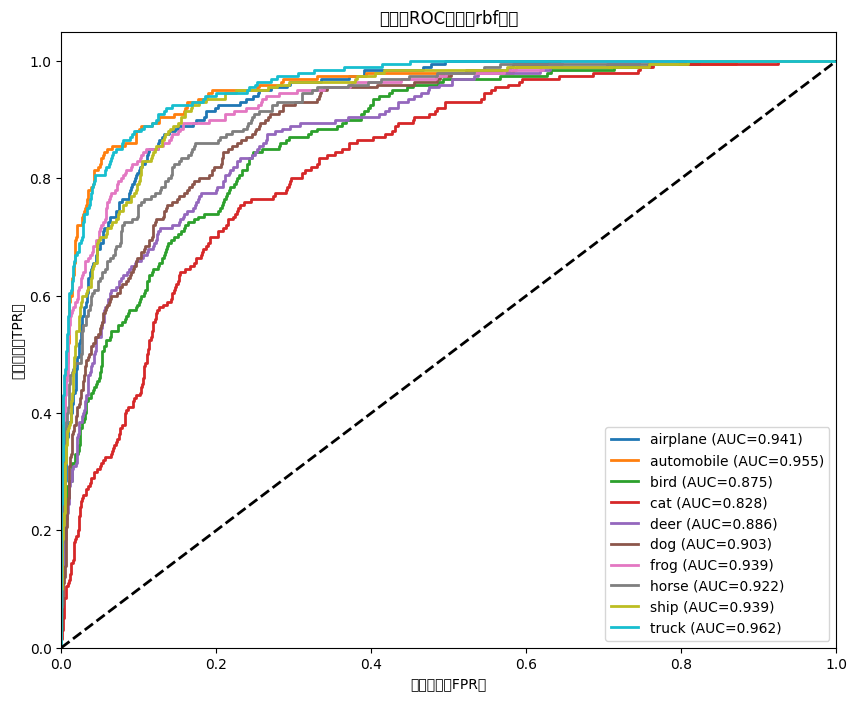

In [25]:
# 3. ROC曲线（多分类One-vs-Rest）
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --------------------------
# 步骤1：获取网格搜索的最优参数（替换未定义的best_params_）
# --------------------------
# 从之前的输出中提取最优参数（已打印：{'C': 8, 'class_weight': {'cat': 1.5, 'dog': 1.2}, 'gamma': 0.002}）
best_params = grid_search.best_params_  # 直接从grid_search对象获取，无需手动输入
best_kernel = 'rbf'  # 最优核函数（之前筛选的结果）

# --------------------------
# 步骤2：训练带概率预测的SVM
# --------------------------
best_svm_prob = SVC(
    kernel=best_kernel,
    C=best_params['C'],
    gamma=best_params['gamma'],
    class_weight=best_params['class_weight'],
    probability=True,  # 开启概率预测
    random_state=42
)
best_svm_prob.fit(x_train_res, y_train_res)  # 用之前过采样的训练数据
y_pred_prob = best_svm_prob.predict_proba(x_test_pca)  # 2维概率数组

# --------------------------
# 步骤3：二值化标签
# --------------------------
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)  # 2维标签数组

# --------------------------
# 步骤4：绘制ROC曲线
# --------------------------
plt.figure(figsize=(10, 8))
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{cls} (AUC={roc_auc:.3f})')

# 绘制随机猜测线
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正例率（FPR）')
plt.ylabel('真正例率（TPR）')
plt.title(f'多分类ROC曲线（{best_kernel}核）')
plt.legend(loc='lower right')
plt.show()

In [18]:
# 保存模型
import joblib
joblib.dump(best_svm, 'cifar10_svm_optimized.pkl')
print("优化模型已保存")

优化模型已保存
